<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px; font-family: garamond;">

<h1><b> Binary Prediction of Poisonous Mushrooms </b></h1>

<a href="https://www.kaggle.com/competitions/playground-series-s4e8">
    <b style="color: #168188;"><u>Playground Series - Season 4, Episode 8</u></b>
</a>

<div style="margin-top: 20px; text-align:center;">
    <img style="max-width: 1567px; max-height: 878px; min-width: 100%; padding: " src="./data/header.png" alt="Playground Series S4E8">
</div>

<b>Overview</b>
Welcome to the 2024 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting an approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

<b>Your Goal:</b> The goal of this competition is to predict whether a mushroom is edible or poisonous based on its physical characteristics.

<b>Dataset Description</b>
The dataset for this competition (both train and test) was generated from a deep learning model trained on the UCI Mushroom dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

<b>Note:</b> Unlike many previous Tabular Playground datasets, data artifacts have not been cleaned up. There are categorical values in the dataset that are not found in the original. It is up to the competitors how to handle this.

<b>Files (297.82 MB)</b>

<li> train.csv - the training dataset; class is the binary target (either e or p)        </li>
<li> test.csv - the test dataset; your objective is to predict target class for each row </li>
<li> sample_submission.csv - a sample submission file in the correct format              </li>
</div>

<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Tabel of Contents</b></h1>
</div>

- <a href="#libraries">1. Import Necessary Libraries</a>
- <a href="#data">2. Reading Training Data</a>
    - <a href="#display">2.1 Display Data</a>
    - <a href="#info">2.2 Show More Info</a>
- <a href="#preprocess">3. Preprocess Data and Cleaning</a>
    - <a href="#duplicated">3.1 Remove Duplicated</a> 
    - <a href="#nanvalue">3.2 Check For NaN values</a>
    - <a href="#rare">3.3 Handle Rare Categories</a>
    - <a href="#num">3.4 Numerical Columns</a> 
    - <a href="#impute">3.5 Impute Missing Data</a> 
- <a href="#nplots">4. Plotting Training Data</a>
    - <a href="#corr">4.1 Feature Correlation</a>
    - <a href="#hist">4.2 Distribution Histogram</a>
    - <a href="#numrels">4.3 Investigating Relationships (Numerical)</a>
    - <a href="#catrels">4.4 Investigating Relationships (Category)</a>
    - <a href="#outliers">4.5 Check For Outliers</a>
    - <a href="#response">4.6 Response Variable</a>
- <a href="#preproces">5. Preproces and Model</a>

<a id="libraries"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Import Necessary Libraries</b></h1>
</div>

In [ ]:
%pip install --upgrade pip --break-system-packages
%pip install -r requirements.txt --break-system-packages

In [23]:
import pandas as pd
import numpy as np 
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

import warnings as wn

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef

palette = sns.color_palette("Spectral", n_colors=13) 
sns.set_theme(context='notebook', palette=palette, style='darkgrid')

In [24]:
# Ignore all warnings
wn.filterwarnings('ignore')

In [25]:
# Set all variables paths 

_plots = './plots/'
_tested = './tested/'
_test = './data/test.csv'
_train = './data/train.csv'
_info = './model/model.docx'
_model = './model/model.pkl'
_submission = './data/sample_submission.csv'

<a id="data"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Reading Training Data</b></h1>
</div>

In [26]:
# Read the training datasets 
train = pd.read_csv(_train, index_col="id")

<a id="display"></a>
<div style="color: #207881; background-color: #104452; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Display Data</b></h3>
</div>

In [6]:
# Display the first n rows of training
train.head(n=10)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.796875,f,s,u,f,a,c,w,4.511719,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.511719,x,h,o,f,a,c,n,4.789062,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.941406,f,s,b,f,x,c,w,6.851562,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.880859,f,y,g,f,s,NaN,g,4.160156,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.851562,x,l,w,f,d,NaN,w,3.369141,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
5,p,4.300781,x,t,n,f,s,c,n,5.910156,...,NaN,NaN,w,NaN,n,t,z,NaN,d,a
6,e,9.648438,p,y,w,f,e,c,k,19.062500,...,NaN,s,w,NaN,NaN,t,e,NaN,g,w
7,p,4.550781,x,e,e,f,a,NaN,y,8.312500,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
8,p,7.359375,f,h,e,f,x,d,w,5.769531,...,b,NaN,w,NaN,NaN,f,f,NaN,d,a


<a id="info"></a>
<div style="color: #207881; background-color: #104452; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Show More Info</b></h3>
</div>

In [27]:
# Describe the data
train.describe(include=['object']).T

,count,unique,top,freq
class,3116945,2,p,1705396
cap-shape,3116905,74,x,1436026
cap-surface,2445922,83,t,460777
cap-color,3116933,78,n,1359542
does-bruise-or-bleed,3116937,26,f,2569743
gill-attachment,2593009,78,a,646034
gill-spacing,1858510,48,c,1331054
gill-color,3116888,63,w,931538
stem-root,359922,38,b,165801
stem-surface,1136084,60,s,327610


In [28]:
# Display more info about the data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 523.2+ MB


In [29]:
# Set the datatype of each column for memory eficiency

for col in train.columns:
    if train[col].dtype == 'object':
        print(f'Column {col} has {train[col].nunique()} unique values')

Column class has 2 unique values
Column cap-shape has 74 unique values
Column cap-surface has 83 unique values
Column cap-color has 78 unique values
Column does-bruise-or-bleed has 26 unique values
Column gill-attachment has 78 unique values
Column gill-spacing has 48 unique values
Column gill-color has 63 unique values
Column stem-root has 38 unique values
Column stem-surface has 60 unique values
Column stem-color has 59 unique values
Column veil-type has 22 unique values
Column veil-color has 24 unique values
Column has-ring has 23 unique values
Column ring-type has 40 unique values
Column spore-print-color has 32 unique values
Column habitat has 52 unique values
Column season has 4 unique values


<a id="preprocess"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Preprocess Data and Cleaning</b></h1>
</div>

<a id="duplicated"></a>
<div style="color: #207881; background-color: #104452; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Remove Duplicated</b></h3>
</div>

In [30]:
# Check for dublicates
print(train.duplicated().sum())
train = train.drop_duplicates()
print(f'New training data: {train.shape}')

0
New training data: (3116945, 21)


<a id="nanvalue"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Check For NaN values</b></h3>
</div>

In [38]:
# Verify if there are null values

print("Every missing value by column:")
print(train.isnull().sum())

Every missing value by column:
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64


<a id="rare"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Handle Rare Categories</b></h3>
</div>

In [32]:
# Remove columns with more then 90% missing values

missing = train.isnull().median()
columns_to_drop = missing[missing > 0.9].index
train = train.drop(columns_to_drop, axis=1)

In [33]:
# Define the target column
target = 'class'
cat_columns = train.select_dtypes(include=['object']).columns
num_columns = train.select_dtypes(exclude=['object']).columns

In [34]:
# Define a function to identify and replace infrequent categories

def replace_infrequent_categories(df, column, threshold=70):
    value_counts = df[column].value_counts()
    infrequent = value_counts[value_counts <= threshold].index
    df[column] = df[column].apply(lambda x: "Unknown" if x in infrequent else x)
    return df

for col in cat_columns:
    train = replace_infrequent_categories(train, col)


<a id="num"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Numerical Columns</b></h3>
</div>

In [35]:
# 
train[num_columns].apply(lambda x: stats.skew(x.dropna()))
medians = train[num_columns].median()
train[num_columns] = train[num_columns].fillna(medians)

<a id="impute"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Impute Missing Data</b></h3>
</div>

In [36]:
# Impute any missing values with 'Unknown'
train = train.fillna("Unknown")

In [72]:
print("Original number of columns:")
print(train.shape[1])

Original number of columns:
16


<a id="nplots"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Plotting Training Data</b></h1>
</div>

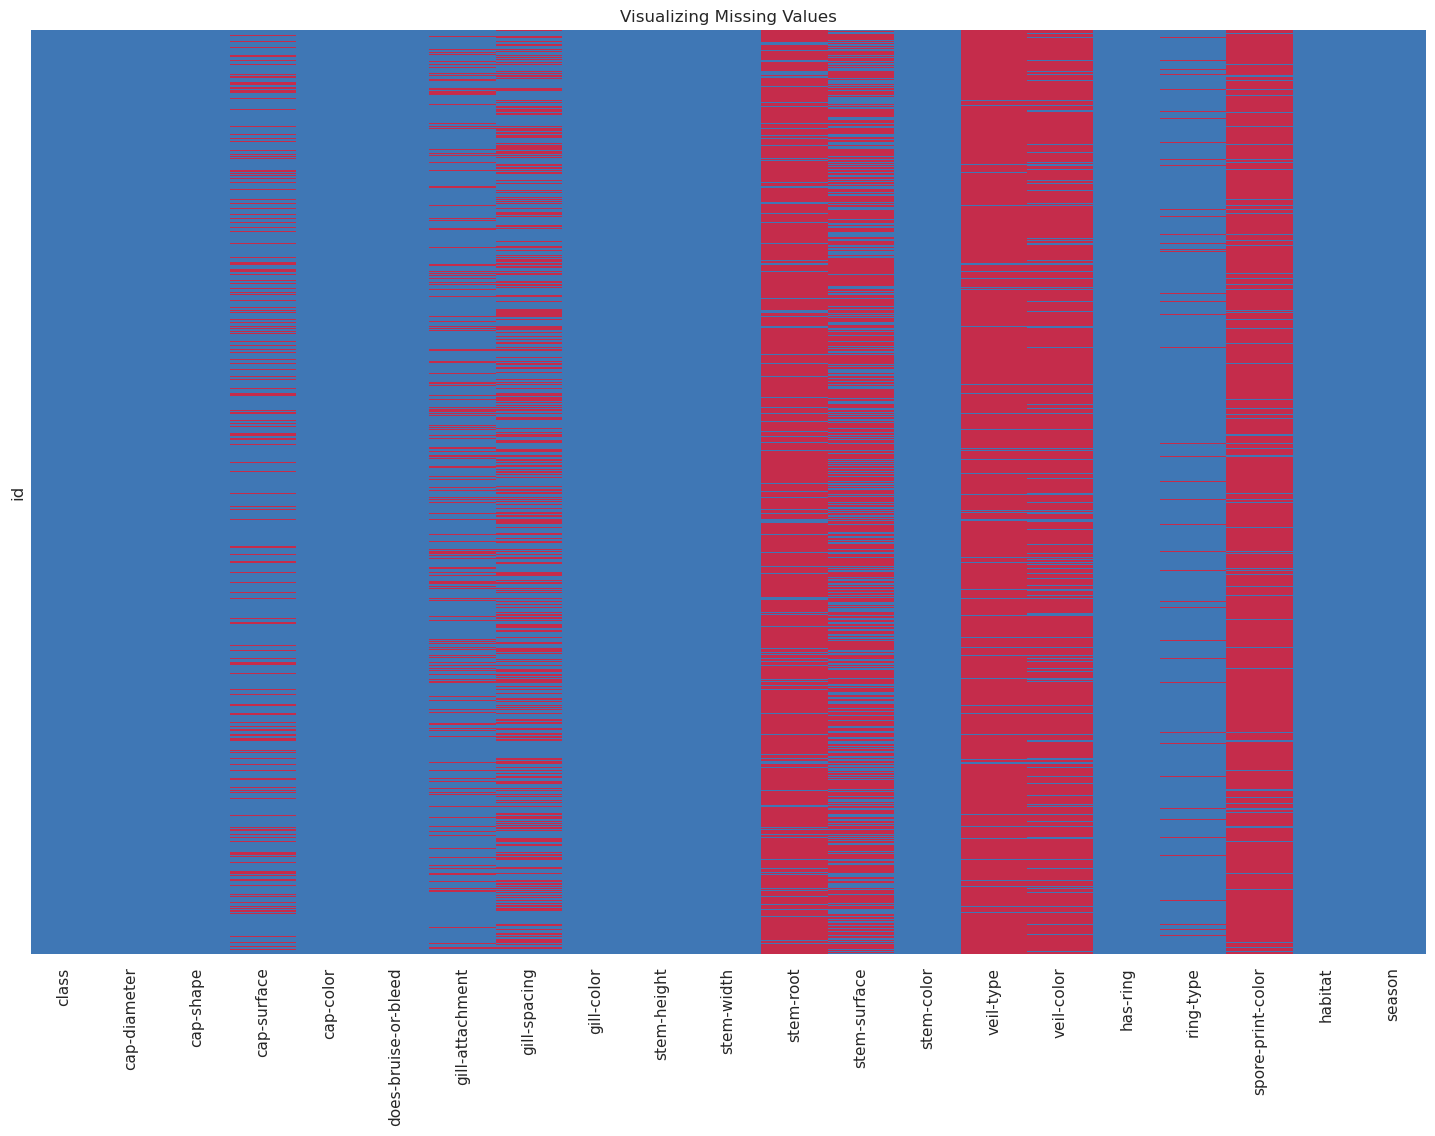

In [31]:
# Create a heatmap to visualize missing values

plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(train.isnull(), 
    cbar=False,     
    cmap=sns.color_palette("Spectral_r", n_colors=13), 
    yticklabels=False
);

<a id="corr"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Feature Correlation</b></h3>
</div>

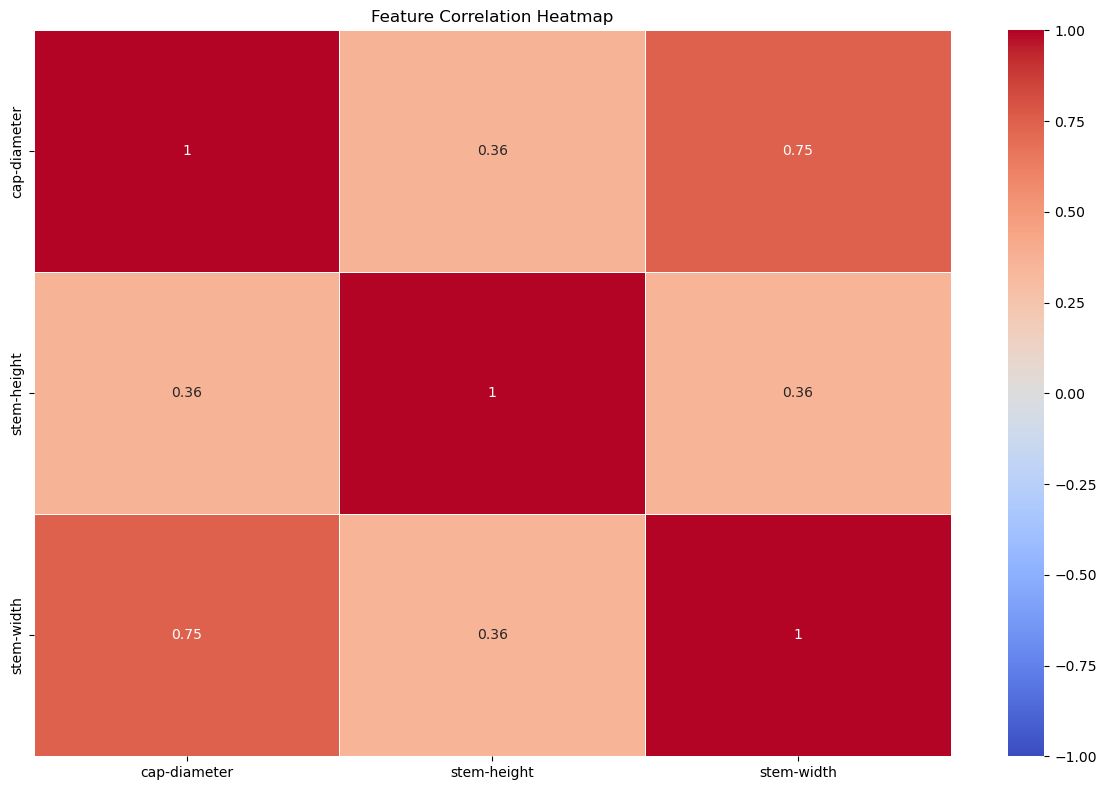

In [16]:
# Calculate the correlation matrix
correlation_matrix = train.corr()

# Plot the numerical heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

<a id="hist"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Distribution Histogram</b></h3>
</div>

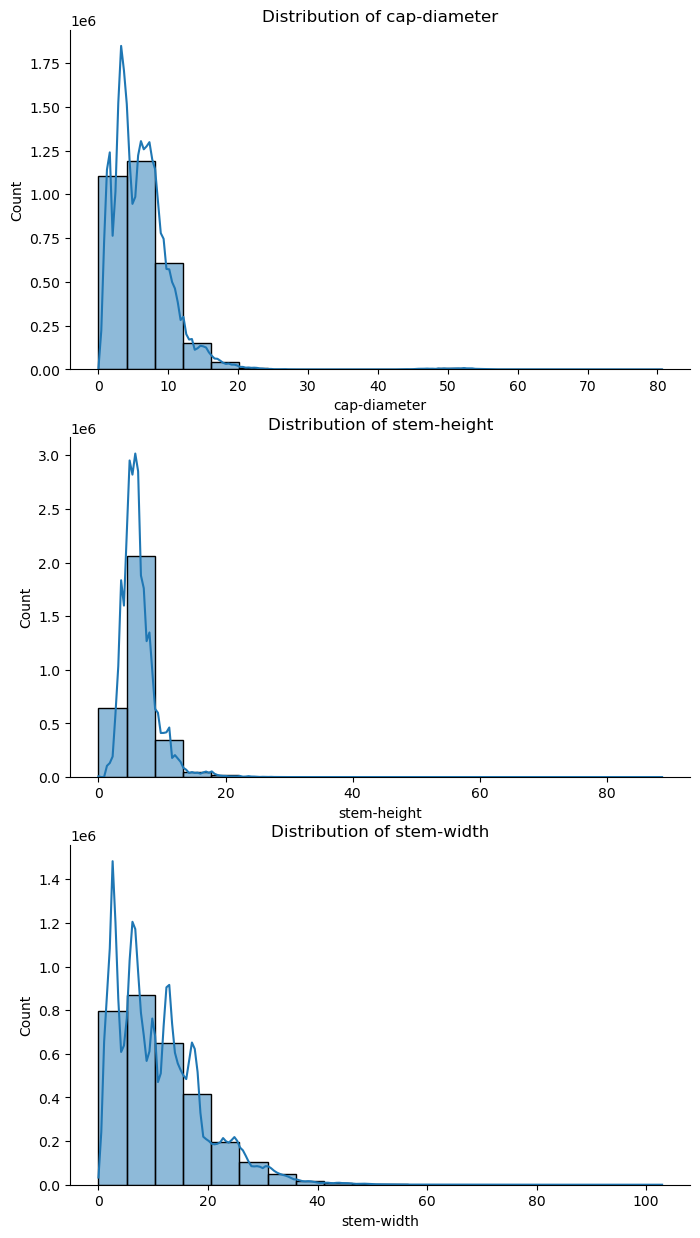

In [73]:
# Plot each numerical column by distribution

num_columns = [col for col in train.columns if train[col].nunique() > 15]
plt.figure(figsize=(8, 15)) 
for i, column in enumerate(num_columns):
    plt.subplot(3, 1, i+1)
    sns.histplot(data=train, x=column, kde=True, bins=20)
    plt.title(f'Distribution of {column}')
    sns.despine()

plt.show()

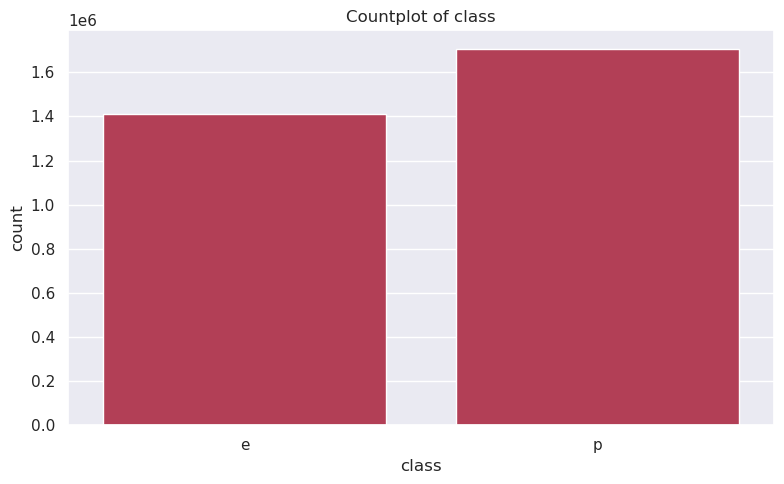

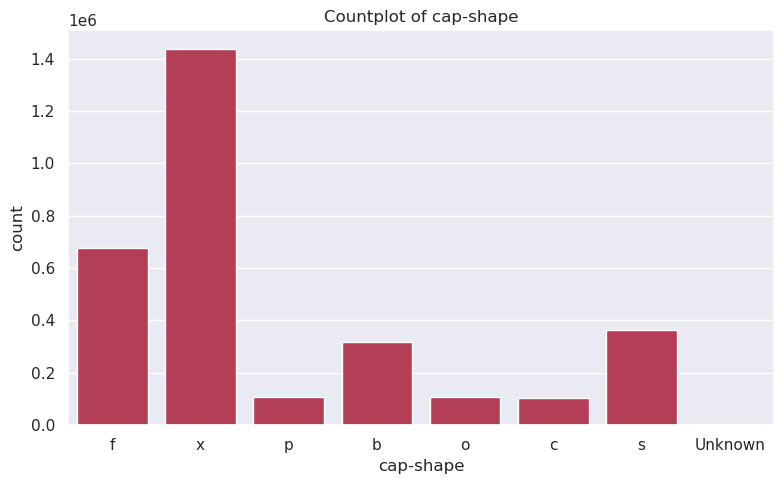

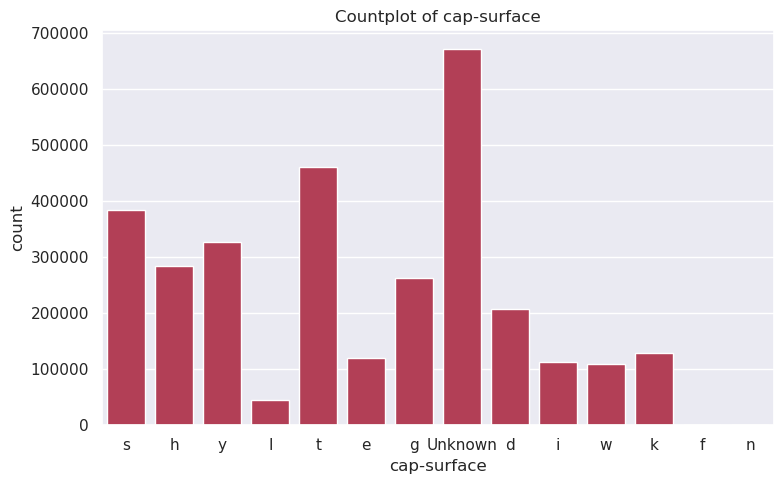

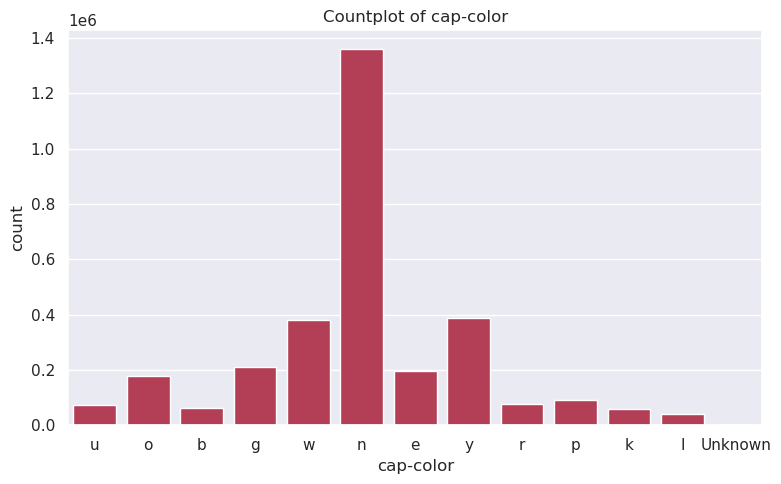

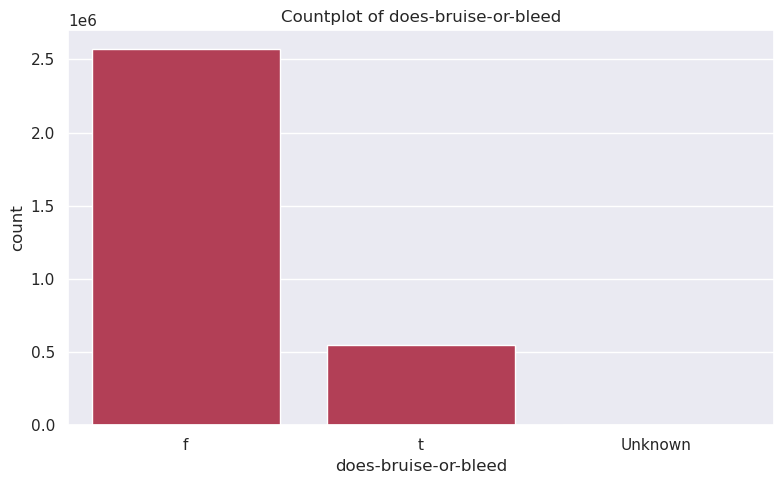

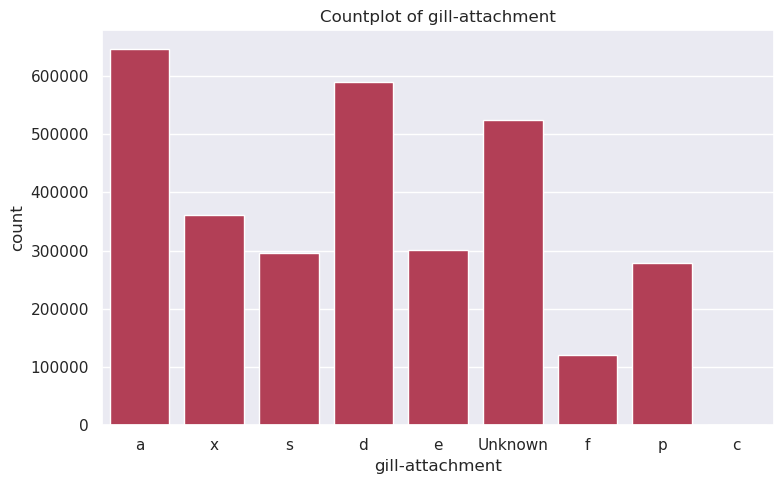

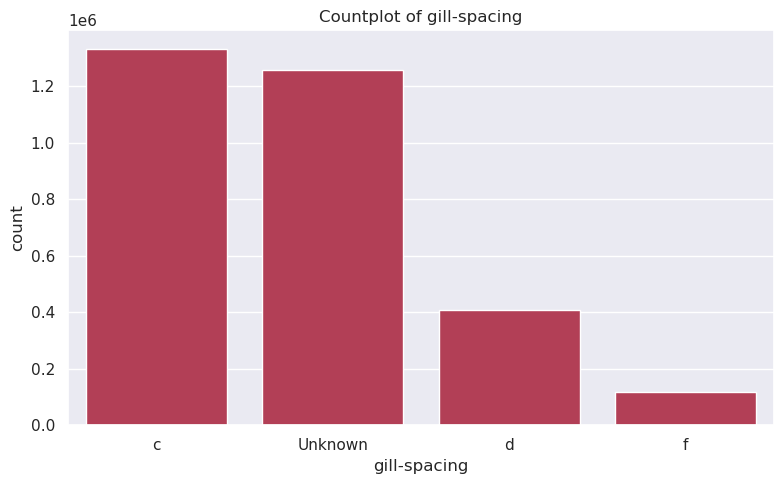

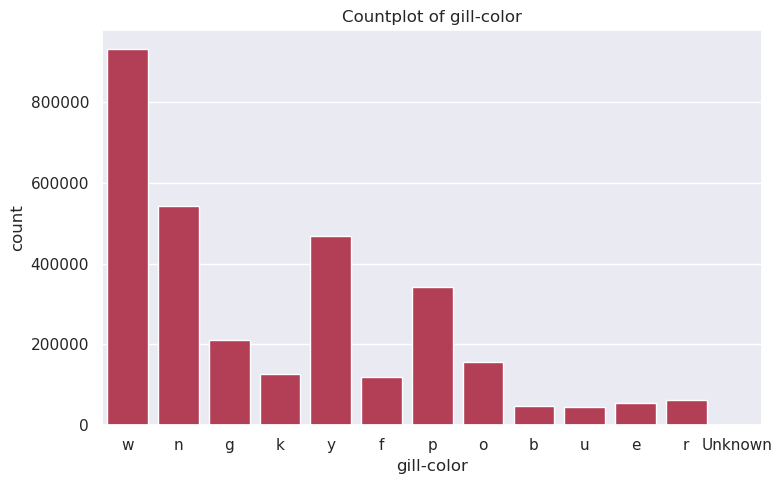

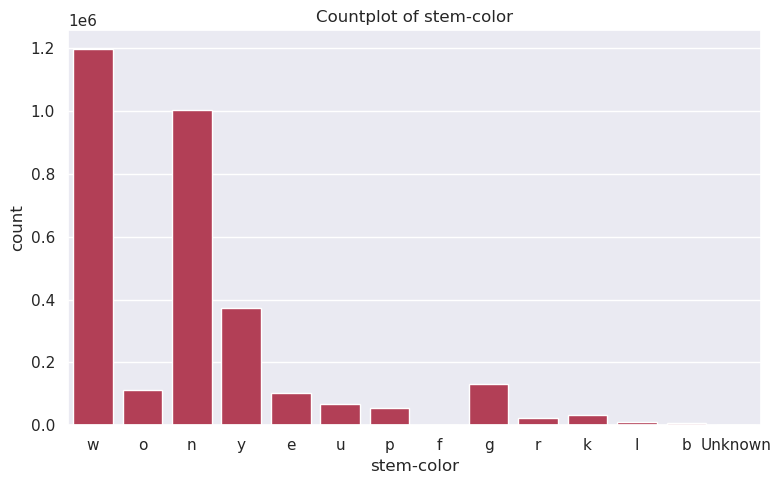

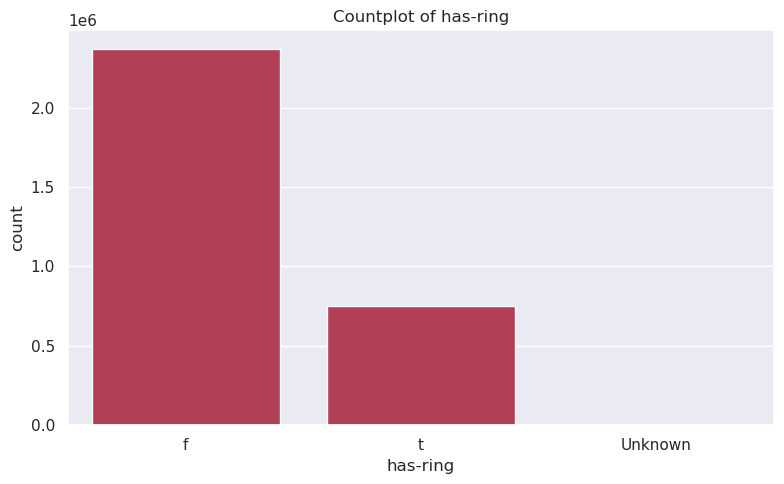

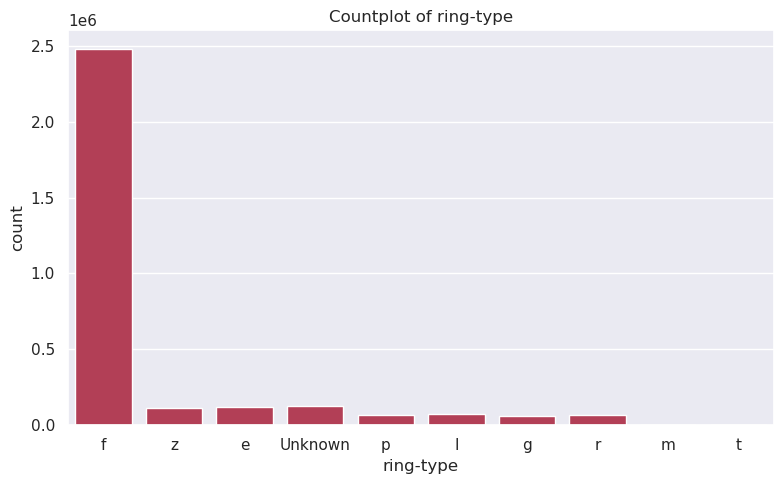

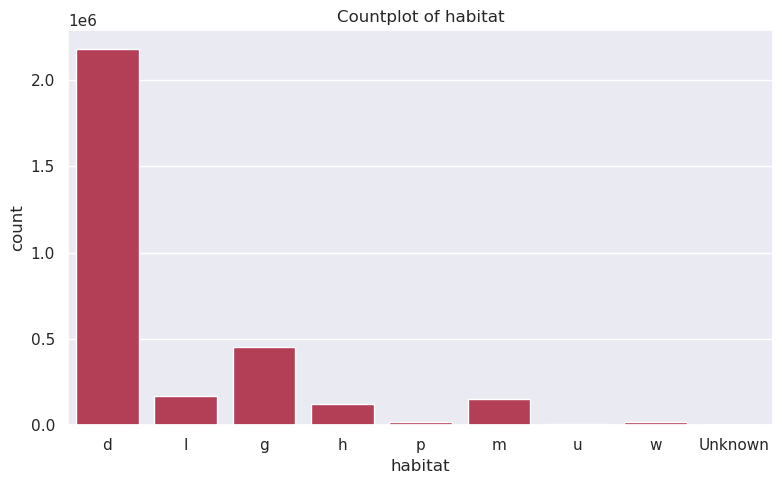

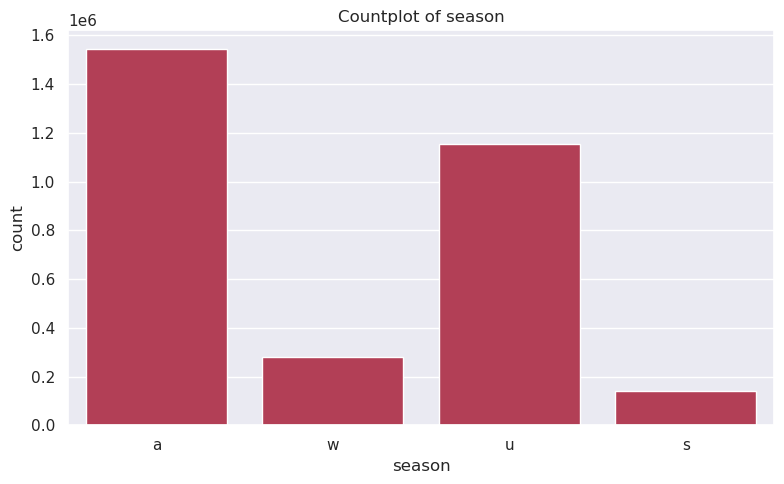

In [37]:
# Plot countplots for each categorical column

for column in cat_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train, x=column)
    plt.title(f'Countplot of {column}')
    
    plt.tight_layout()
    plt.show()

<a id="numrels"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Investigating Relationships (Numerical)</b></h3>
</div>

In [ ]:
# Display the correlations in float dtype columns 

custom_palette = sns.color_palette(["#102A3B", "#168188"])
pairplot = sns.pairplot(df_train_cleaned, hue='class', palette=custom_palette)
pairplot.figure.suptitle('Relationship', fontsize=22, y=1.02)
plt.show()

<a id="catrels"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Investigating Relationships (Category)</b></h3>
</div>

In [ ]:
# Use the mosaic plot for data relations

for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    mosaic(df_train_cleaned, [column, 'class'])
    plt.title(f'Mosaic Plot of {column} and class')

    plt.tight_layout()
    plt.show()

<a id="outliers"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Check For Outliers</b></h3>
</div>

In [ ]:
# Calculate the Z-scores for the numerical columns in the DataFrame
z_scores = stats.zscore(df_train_cleaned[numerical_columns])

# Generate descriptive statistics for the Z-scores and round the results to 3 decimal places
z_scores.describe().round(3)

In [ ]:
numerical_df = df_train_cleaned[numerical_columns]

# Create a DataFrame for Z-scores
z_scores_df = pd.DataFrame(z_scores, columns=numerical_df.columns)

# Define the threshold
threshold = 3

# Filter out rows with any Z-score above the threshold in numerical columns
df_train_no_outliers = df_train_cleaned[(z_scores_df.abs() < threshold).all(axis=1)]

<a id="response"></a>
<div style="background-color: #104452; color: #207881; padding: 1px;border-radius: 20px">
    <h3 style="text-align:center; font-family: garamond; margin: 10px;"><b>Response Variable</b></h3>
</div>

In [ ]:
# Calculate counts for the pie chart and add labels
class_counts = df_train_no_outliers['class'].value_counts().sort_index()
labels = ["Edible", "Poisonous"]

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=labels, colors=custom_palette,
        autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Classes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<a id="preproces"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Preproces and Model</b></h1>
</div>

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
train_encoded_target = label_encoder.fit_transform(df_train_no_outliers[['class']])

# Convert categorical columns to 'category' dtype 
df_train_no_outliers[categorical_columns] = df_train_no_outliers[categorical_columns].astype('category')
df_test_cleaned[categorical_columns] = df_test_cleaned[categorical_columns].astype('category')

# Define the numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('convert_to_float32', FunctionTransformer(lambda x: x.astype(np.float32)))
])

# Define the categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', dtype=np.int32, handle_unknown='ignore'))
])

# Combine both numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)

# Apply the transformations using the pipeline
df_train_encoded = preprocessor.fit_transform(df_train_no_outliers)
df_test_encoded = preprocessor.transform(df_test_cleaned)

# Ensure outputs are dense arrays
train_encoded_dense = df_train_encoded.toarray()
test_encoded_dense = df_test_encoded.toarray()

# Get feature names
numerical_feature_names = numerical_columns  # Assuming numerical columns do not change names
categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns)

# Combine the feature names
all_feature_names = np.concatenate([numerical_feature_names, categorical_feature_names])

# Debugging: Print the number of feature names
print("Number of Features:", len(all_feature_names))

# Convert the transformed dense arrays back into DataFrames
train_encoded_df = pd.DataFrame(train_encoded_dense, columns=all_feature_names)
test_encoded_df = pd.DataFrame(test_encoded_dense, columns=all_feature_names)

<a id="models"></a>
<div style="background-color: #102A3B; color: #168188; padding: 20px; border-radius: 20px">
    <h1 style="text-align:center; font-family: garamond"><b>Testing All Models</b></h1>
</div>

<div style="background-color: #102A3B; color: #157780; padding: 20px; border-radius: 20px">
    <h1 style="font-family: garamond;"><b>Models</b></h1>
    <li> K-Nearest Neighboor Model          </li>    
    <li> Gaussian Naive Bayes Model         </li>    
    <li> Logistic Regressor                 </li>    
    <li> Support Vector Classification Model</li>    
    <li> Decision Tree Model                </li>    
    <li> Random Forest Model                </li>    
    <li> Linear Discriminant Analysis Model </li>    
    <li> Gradient Boosting Classifier Model </li>    
    <li> Neural Network CLassifier Model    </li>    
    <li> X Gradient Boost Classifier        </li>    
    <li> Cat Boosting Classifier            </li>    
    <li> Ada Boosting Classifier            </li>
    <li> Quadratic Discriminant Analysis    </li>    
    <li> Perceptron Classifier Model        </li>
    <li> Ridge Classifier Model             </li>
    <li> Logistic Regression CV             </li>
    <li> Bagging Classifier Model           </li>
    <li> Extra Trees Classifier             </li>
    <li> Passive Aggressive Classifier      </li>
    <li> Hist Gradient Boosting Classifier  </li>
</div>

# K-NearestNeighboor Model 

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print(classification_report(y_test, knn_pred))

# Gaussian Naive Bayes Model 

In [38]:
from sklearn.naive_bayes import GaussianNB

In [40]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)
print(classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           1       0.55      0.68      0.61    282463
           2       0.67      0.54      0.60    340926

    accuracy                           0.61    623389
   macro avg       0.61      0.61      0.61    623389
weighted avg       0.62      0.61      0.61    623389



# Logistic Regression Model

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           1       0.62      0.53      0.57    282463
           2       0.65      0.73      0.69    340926

    accuracy                           0.64    623389
   macro avg       0.64      0.63      0.63    623389
weighted avg       0.64      0.64      0.64    623389

